In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

# Use the following lines to test the basic functionality of the package if developing locally: 
import sys, os
sys.path.insert(0, "../src/")
from graph import *

This notebook showcases the first few steps of the Omics Integrator network analysis pipeline: 
1. Parameter selection
2. Randomization experiments

In order to use the inline R visualizations, please follow the setup instructions [here](https://www.datacamp.com/community/blog/jupyter-notebook-r).

In [2]:
def summarize_grid_search(graph, results, mode, top_n=-1): 
    """
    Summarizes results of `_grid_randomization` into a matrix where each row is a gene 
    and each column is a parameter run. Values may be binary, to indicate node membership,
    or robustness/specificity values. Also, node attributes columns are added for 
    plotting purposes.

    Arguments:
        graph (obj): Graph object (this may be better implemented as a method)
        results (list of tuples): Results of `_grid_randomization` (paramstring, forest, augmented forest)
        mode (str): Reported values "membership", "robustness", "specificity"
        top_n (int): Takes the top_n values of the summary dataframe. top_n=-1 sets no threshold

    Returns:
        df (DataFrame): Values summarized across experiments, including node attributes columns
    """
    
    # Exclude any degenerate results
    results = {paramstring: graphs for paramstring, graphs in results.items() if graphs["augmented_forest"].number_of_nodes() > 0}
    
    if mode == "membership": # Summarize single-run parameter search
        dfs = [(get_networkx_graph_as_dataframe_of_nodes(graphs["augmented_forest"])["degree"]>0).astype(int) for graphs in results.values()]
    elif mode == "robustness": # Summarize randomized robustness
        dfs = [get_networkx_graph_as_dataframe_of_nodes(graphs["augmented_forest"])["robustness"] for graphs in results.values()]
    elif mode == "specificity": # Summarize randomized specificity
        dfs = [get_networkx_graph_as_dataframe_of_nodes(graphs["augmented_forest"])["specificity"] for graphs in results.values()] 
    else:
        print("Must specificy a correct mode: 'membership', 'robustness', or 'specificity'.")
        return
    
    df = pd.concat(dfs, axis=1).fillna(0)
    df.columns = results.keys()
    
    # Fetch node attributes
    degrees = pd.DataFrame.from_dict({node: len(graph.interactome_graph[node]) for node in df.index}, orient="index")
    degrees["log_degree"] = np.log2(degrees[0])

    prizes_dataframe = pd.read_csv(prize_file, sep='\t').set_index("name")

    df = pd.concat([df, degrees["log_degree"]], axis=1).merge(prizes_dataframe, left_index=True, right_index=True, how="left")
    df["type"] = df["type"].fillna(value="steiner")
    df.fillna(0, inplace=True)
    
    # df can get quite large with many sparse entries, so let's filter for the top_n entries
    if top_n == -1: 
        return df
    
    if len(df) > top_n: 
        cutoff = sorted(df.sum(axis=1).tolist(), reverse=True)[top_n]
        df = df[df.sum(axis=1)>cutoff]
    
    return df

In [3]:
def get_networkx_subgraph_from_randomizations(nxgraph, max_size=400): 
    """
    Approach 1: from entire network, attempt to remove lowest robustness node. If removal results in a component 
    of size less than min_size, do not remove. 
    Approach 2: select top max_size nodes based on robustness, then return subgraph. 
    """

    node_attributes_df = get_networkx_graph_as_dataframe_of_nodes(nxgraph)
    top_hits = node_attributes_df.index[:min(max_size,node_attributes_df.shape[0])]
    
    if nxgraph.size() == 0: return nxgraph

    if "robustness" not in node_attributes_df.columns: 
        print("WARNING: 'robustness' is not an attribute in subgraph, subgraph may not be meaningful.")

    # Get robust subnetwork and remove singleton nodes.
    robust_network = nxgraph.subgraph(top_hits)
    robust_network = prune_network_graph(robust_network)

    return robust_network


def prune_network_graph(nxgraph, min_size=5): 
    # Removes any components that are less than min_size
    
    tmp = nxgraph.copy()

    if tmp is None: return 

    small_components = [g.nodes() for g in nx.connected_component_subgraphs(nxgraph, copy=True) if g.number_of_nodes() < min_size]
    nodes_to_remove = [item for sublist in small_components for item in sublist]
    tmp.remove_nodes_from(nodes_to_remove)
    
    return tmp

In [4]:
# Load R plotting libraries

%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr)

array([1], dtype=int32)

In [5]:
%%R 

library(ComplexHeatmap)
library(circlize)
library(colorspace)
library(GetoptLong)


plotHeatmap <- function(nodes) {
"Visualizes a heatmap of summarized experiments generated by `summarize_grid_search`.

Arguments:
    nodes (df): Values summarized across experiments, including node attributes columns"
    
    mat <- t(nodes[, grep("W_", colnames(nodes))])

    names <- colnames(nodes)[grep("W_", colnames(nodes))]
    tmp <- data.frame(do.call(rbind, strsplit(names, '_', fixed=TRUE)))[,c(2,4,6)]
    colnames(tmp) <- c("w", "b", "g")
    indx <- sapply(tmp, is.factor)
    tmp[indx] <- lapply(tmp[indx], function(x) as.numeric(as.character(x)))
    tmp$g <- log10(tmp$g)

    annotation_df = nodes[,c("type", "log_degree", "prize")]
    ha = HeatmapAnnotation(
        df=annotation_df, 
        col=list(
            prize = colorRamp2(c(0,max(nodes$prize)), c("white", "orange")), 
            log_degree=colorRamp2(c(0,5,max(nodes$log_degree)), c("blue", "white", "red")), 
            type=c("steiner"="blue", "terminal"="red", "TF"="green")
        ), 
        annotation_legend_param=list(
            prize=list(legend_direction="horizontal"),
            log_degree=list(legend_direction="horizontal"),
            type=list(legend_direction="horizontal")
        )
    )

    ht = Heatmap(
        mat, 
        name="Node Membership", 
        col=c("white", "black"), 
        show_column_names=F, 
        top_annotation=ha, 
        top_annotation_height=unit(12, "mm")
    ) + 
        Heatmap(tmp$w, name="W", col=colorRamp2(c(0, max(tmp$w)), c("white", "red")), width=unit(6, "mm")) +
        Heatmap(tmp$b, name="B", col=colorRamp2(c(0, max(tmp$b)), c("white", "blue")), width=unit(6, "mm")) +
        Heatmap(tmp$g, name="G", col=colorRamp2(c(0, max(tmp$g)), c("white", "green")), width=unit(6, "mm"))

    draw(ht, heatmap_legend_side = "right", annotation_legend_side = "top")
}

# 0. Omics Integrator 2 Inputs

In [6]:
interactome_file = "/Users/jonathanli/Documents/research/ALS/data/interactome/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
prize_file = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/prizes.txt"
output_dir = "/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/"

Ws = [0.25, 0.5, 0.75, 1]
Bs = [0.25, 0.5, 0.75, 1, 1.5, 2]
Gs = [1000, 3000, 10000, 30000]

params = {
    "noise": 0.1, 
    "dummy_mode": "terminals", 
    "exclude_terminals": False, 
    "seed": 1
}

graph = Graph(interactome_file, params)
graph.prepare_prizes(prize_file)

06:34:09 - Graph: INFO - Duplicated edges in the interactome file (we'll keep the max cost):
06:34:09 - Graph: INFO - []
06:34:11 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:34:11 - Graph: INFO - ['HNRNPA2B1']
06:34:11 - Graph: INFO - Members of the prize file not present in the interactome:
06:34:11 - Graph: INFO - []


In [7]:
# Format of prize file
pd.read_csv(prize_file, sep='\t').head()

,name,prize,type
0,ANXA2,1.149461,terminal
1,ATM,0.453498,terminal
2,BDH2,0.472954,terminal
3,CBX1,0.895977,terminal
4,CBX3,0.479893,terminal


# 1. Parameter sweep

In [8]:
results = graph.grid_search(prize_file, Ws, Bs, Gs)

06:34:11 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:34:11 - Graph: INFO - ['HNRNPA2B1']
06:34:11 - Graph: INFO - Members of the prize file not present in the interactome:
06:34:11 - Graph: INFO - []
06:34:13 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_1000
06:34:13 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_30000
06:34:14 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_10000
06:34:14 - Graph: INFO - Single PCSF runs for W_0.25_B_0.75_G_3000
06:34:14 - Graph: INFO - Single PCSF runs for W_0.25_B_0.25_G_3000
06:34:15 - Graph: INFO - Single PCSF runs for W_0.25_B_1.00_G_1000
06:34:15 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_1000
06:34:15 - Graph: INFO - Single PCSF runs for W_0.25_B_1.00_G_30000
06:34:16 - Graph: INFO - Single PCSF runs for W_0.25_B_0.50_G_30000
06:34:16 - Graph: INFO - Single PCSF runs for W_0.25_B_1.50_G_10000
06:34:16 - Graph: INFO - Single PCSF runs for W_0.25_B_2.00_G_3000
06:34:16 - Gr

In [9]:
membership_df = summarize_grid_search(graph, results, "membership")

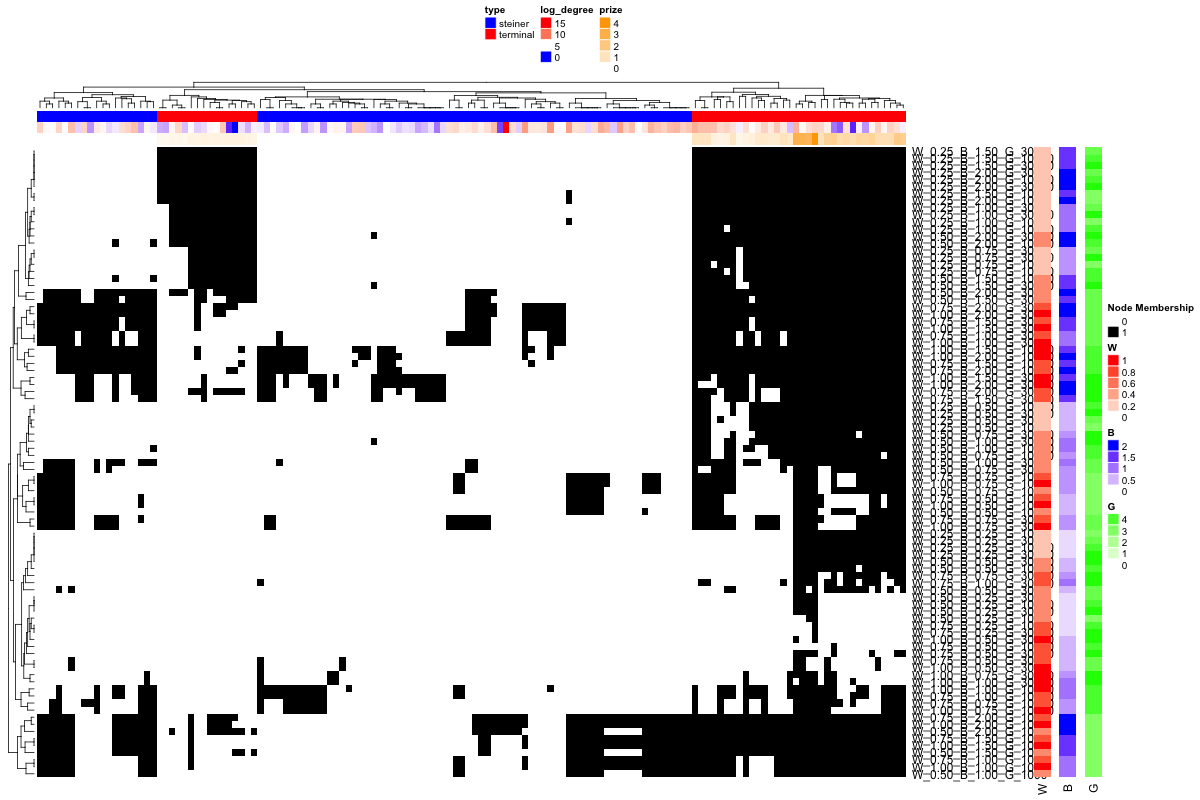

In [10]:
%%R -i membership_df -w 1200 -h 800 -u px

plotHeatmap(membership_df)

# 2. Randomization

In [11]:
results = graph.grid_randomization(prize_file, Ws, Bs, Gs, 5, 5)

06:34:46 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:34:46 - Graph: INFO - ['HNRNPA2B1']
06:34:47 - Graph: INFO - Members of the prize file not present in the interactome:
06:34:47 - Graph: INFO - []
06:34:48 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_1000
06:34:49 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_30000
06:34:49 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_10000
06:34:50 - Graph: INFO - Randomizations for W_0.25_B_0.75_G_3000
06:34:50 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_1000
06:34:51 - Graph: INFO - Randomizations for W_0.25_B_1.00_G_30000
06:34:52 - Graph: INFO - Randomizations for W_0.25_B_1.50_G_10000
06:34:52 - Graph: INFO - Randomizations for W_0.25_B_2.00_G_3000
06:34:53 - Graph: INFO - Randomizations for W_0.25_B_0.25_G_3000
06:34:54 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_1000
06:34:54 - Graph: INFO - Randomizations for W_0.25_B_0.50_G_30000
06:34:55 - Graph: INFO - Randomizat

In [12]:
for paramstring, forests in results.items(): 
    forests["robust"] = get_networkx_subgraph_from_randomizations(forests["augmented_forest"], 400)

In [13]:
robustness_df = summarize_grid_search(graph, results, "robustness", top_n=1000)
specificity_df = summarize_grid_search(graph, results, "specificity", top_n=1000)

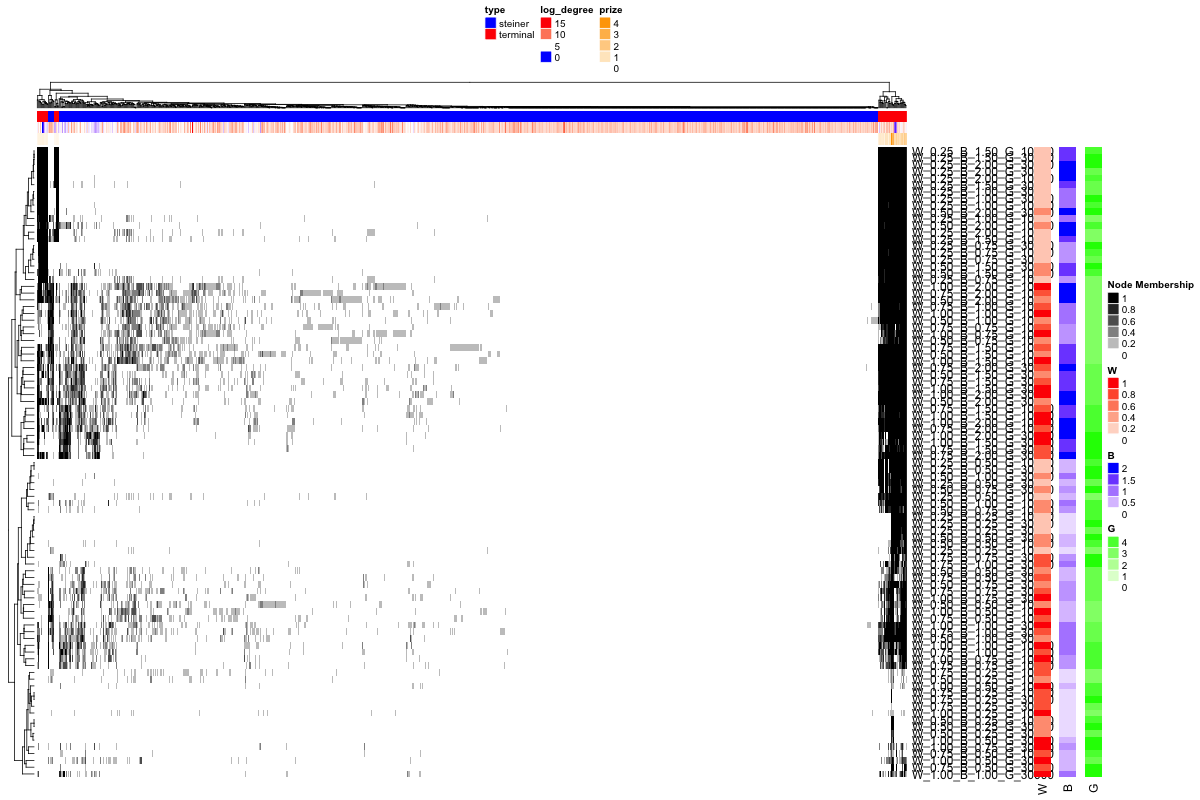

In [14]:
%%R -i robustness_df -w 1200 -h 800 -u px

plotHeatmap(robustness_df)

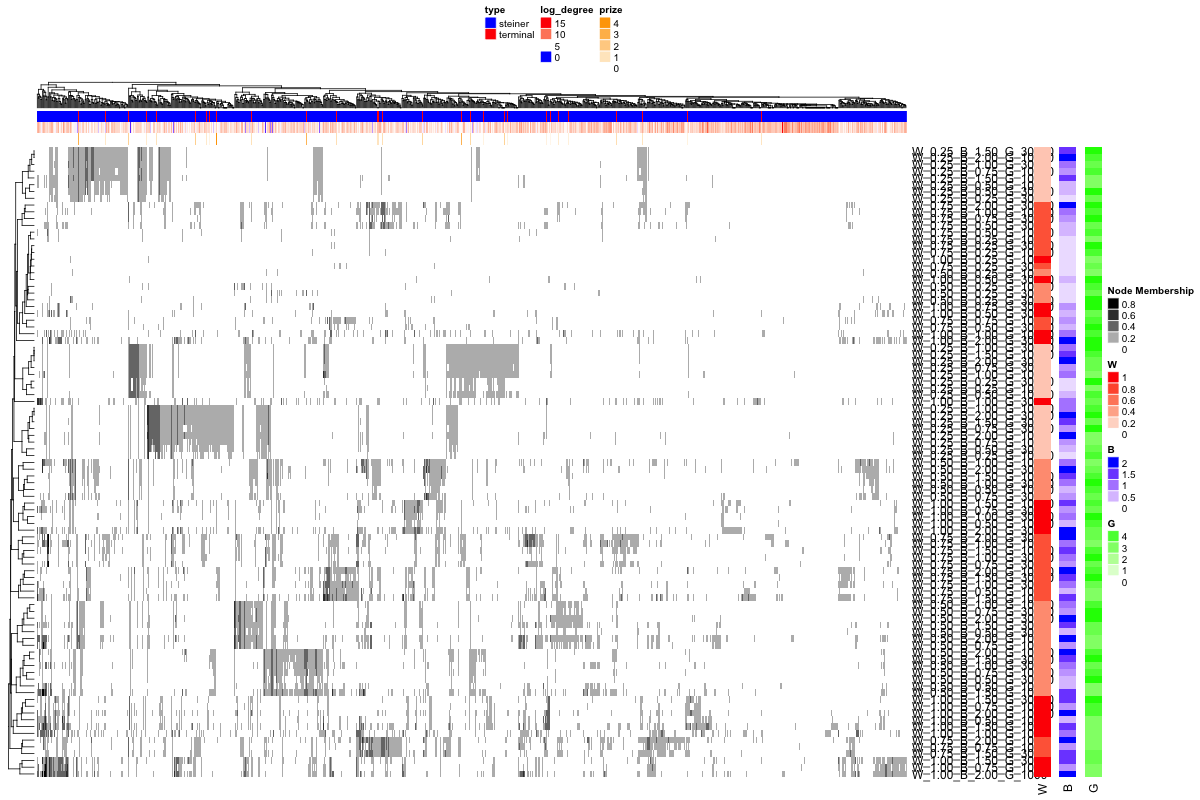

In [15]:
%%R -i specificity_df -w 1200 -h 800 -u px

plotHeatmap(specificity_df)

# 3. Output networkx graph for visualization

In [16]:
output_networkx_graph_as_graphml_for_cytoscape(results["W_0.25_B_0.50_G_10000"]["robust"], output_dir=output_dir, filename="W_0.25_B_0.50_G_10000.robust_network.graphml")

'/Users/jonathanli/Documents/research/ALS/network_analysis/fly_networks_20180416/W_0.25_B_0.50_G_10000.robust_network.graphml'